# Neural Network Classification in Pytorch

## Neural Network Architecture
Generally speaking a neural network will have the following hyperparameters
- Input Layer
- Hidden Layers
- Neurons per layer
- Output Layer shape (varies depending on number of classes in classification problem)
- Hidden Layer Activation
- Output Layer Activation
- Loss function
- Optimizer

Let's start by getting some data

In [1]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
X, y = make_circles(n_samples=1000, noise=0.1, random_state=42)
print(X[:5])
print(y[:5])

[[ 0.71210844  0.28469831]
 [-0.67871584  0.20727355]
 [-0.86602567  0.34365139]
 [-0.51764775  0.62059874]
 [ 0.4540887  -0.89046586]]
[1 1 1 1 0]


LEt's put our dataset into a pandas dataframe

In [2]:
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.712108,0.284698,1
1,-0.678716,0.207274,1
2,-0.866026,0.343651,1
3,-0.517648,0.620599,1
4,0.454089,-0.890466,0
5,-0.445483,0.787044,1
6,-0.022038,0.811310,1
7,0.729897,0.188943,1
8,-0.191616,-0.815790,1
9,-0.083442,1.093954,0


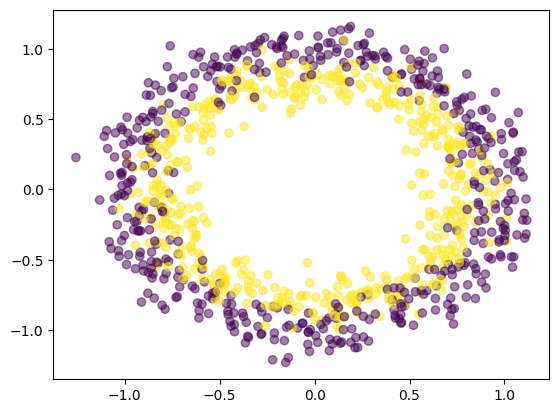

In [3]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1],c=y,alpha=0.5)

Let' try to build a neural network to classify 

In [4]:
import torch
from torch import nn
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
X = torch.from_numpy(X).float()
y = torch.from_numpy(y).float()

split our data for cross validation

In [24]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

Now our data is ready let's start building our model

In [7]:
class CircleModel_v0(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        #construct a 2-layer neural network that splits our input into 5 neurons, then 1 neuron
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(2,5)
        self.layer_2 = nn.Linear(5,1)
    
    def forward(self, x):
        #feed the input through the layers, no activation function for now
        return self.layer_2(self.layer_1(x))
model_v0 = CircleModel_v0().to(device)

In [8]:
untrained_pred = model_v0(X_test.to(device))
#make sure the length of the prediction is the same as the length of the test set
len(untrained_pred) == len(y_test)

True

Now let's declare an optimizer and a loss function so we can train our neural net

In [9]:
from torch.optim import SGD
from torch.nn import BCEWithLogitsLoss
#instantiate the loss function
loss_function = BCEWithLogitsLoss()
#instantiate the optimizer
optimizer = SGD(model_v0.parameters(), lr=0.1)
#define an accuracy metric
def accuracy_fn(y_pred,y_true):
    correct = torch.eq(y_pred,y_true).sum()
    accuracy = correct.float() / len(y_true) * 100
    return accuracy

Now let's write a training loop

In [10]:

epochs = 100
loss_vals = []
accuracy = []

#set the model to train mode
model_v0.train()
for epoch in range(epochs):
    #calculate the prediction
    pred = model_v0(X_train).squeeze()
    pred_labels = torch.round(torch.sigmoid(pred))
    #calculate the loss
    loss = loss_function(pred,y_train)
    #zero the gradients
    optimizer.zero_grad()
    #backpropagate
    loss.backward()
    #update the parameters
    optimizer.step()
    #calculate the accuracy
    acc = accuracy_fn(pred_labels,y_train)
    loss_vals.append(loss)
    accuracy.append(acc)
    with torch.inference_mode():
        model_v0.eval()
        test_pred = model_v0(X_test).squeeze()
        test_loss = loss_function(test_pred,y_test)
        test_acc = accuracy_fn(torch.round(torch.sigmoid(test_pred)),y_test)
        if epoch % 10 == 0:
            print(f"Epoch {epoch} Training Loss: {loss} Training Accuracy: {acc} Test Loss: {test_loss} Test Accuracy: {test_acc}")

Epoch 0 Training Loss: 0.7158198356628418 Training Accuracy: 46.625 Test Loss: 0.726134181022644 Test Accuracy: 47.0
Epoch 10 Training Loss: 0.7051482200622559 Training Accuracy: 48.0 Test Loss: 0.7148113250732422 Test Accuracy: 47.5
Epoch 20 Training Loss: 0.7006555199623108 Training Accuracy: 50.0 Test Loss: 0.7093225121498108 Test Accuracy: 49.499996185302734
Epoch 30 Training Loss: 0.6984896659851074 Training Accuracy: 49.625 Test Loss: 0.7062045931816101 Test Accuracy: 49.499996185302734
Epoch 40 Training Loss: 0.6972700357437134 Training Accuracy: 49.75 Test Loss: 0.7041640877723694 Test Accuracy: 48.5
Epoch 50 Training Loss: 0.6964788436889648 Training Accuracy: 49.875 Test Loss: 0.7026833295822144 Test Accuracy: 48.0
Epoch 60 Training Loss: 0.6959103345870972 Training Accuracy: 49.625 Test Loss: 0.7015353441238403 Test Accuracy: 48.0
Epoch 70 Training Loss: 0.6954748630523682 Training Accuracy: 50.0 Test Loss: 0.700608491897583 Test Accuracy: 48.0
Epoch 80 Training Loss: 0.6951

This is not going well, let's see why

In [11]:
#Download some pytorch helper functions
import requests
from pathlib import Path
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)

helper_functions.py already exists


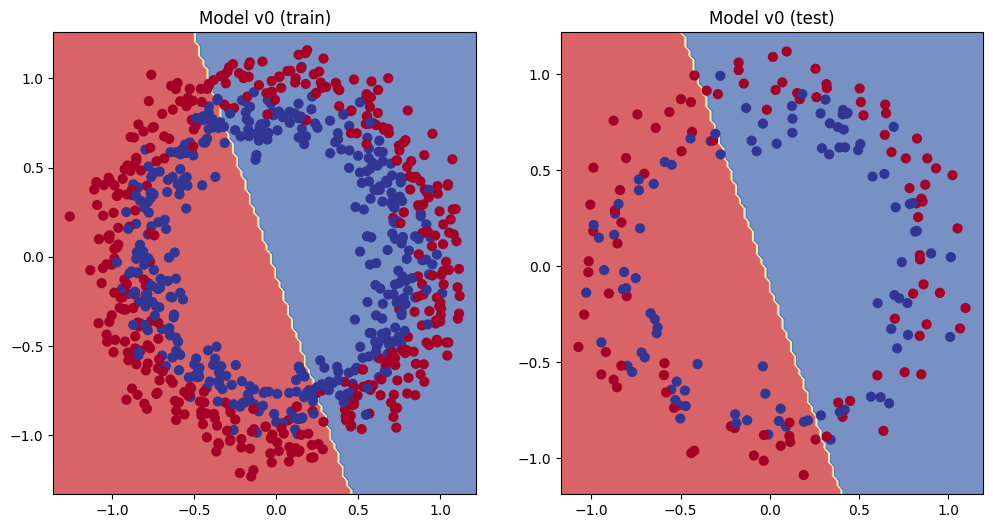

In [12]:
from helper_functions import plot_predictions,plot_decision_boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Model v0 (train)")
plot_decision_boundary(model_v0,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Model v0 (test)")
plot_decision_boundary(model_v0,X_test,y_test)


Since we only have 1 hidden layer our neural net is creating a linear estimation of circular data. There's a couple different ways to improve a model if it's not making accurate predictions
- Increase the number of hidden layers
- Increase the number of hidden units
- Increase the number of training epochs
- Change the activation function
- Change the loss function
- Change the optimizer
- Change the learning rate
- Use a pretrained model (transfer learning)

Let's see if adding more layers works

In [20]:
#define a new model
class CircleModelV1(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.layer_1 = nn.Linear(2,10)
        self.layer_2 = nn.Linear(10,5)
        self.layer_3 = nn.Linear(5,1)
    def forward(self, x):
        return self.layer_3(self.layer_2(self.layer_1(x)))
    
model_v1 = CircleModelV1().to(device)
#use the same loss function and optimizer as before
loss_function = BCEWithLogitsLoss()
optimizer = SGD(model_v1.parameters(), lr=0.1)

Let's write another training loop for this model, this time with 1000 epochs. Maybe the longer training time will help

In [21]:
torch.manual_seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.2, random_state=42)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)
epochs = 1000
model_v1.train()
for epoch in range(epochs):
    #make predictions
    pred = model_v1(X_train).squeeze()
    #round the predictions to get the labels
    pred_labels = torch.round(torch.sigmoid(pred))
    #calculate the loss
    loss = loss_function(pred,y_train)
    #calculate the accuracy
    acc = accuracy_fn(pred_labels,y_train)
    #zero the gradients
    optimizer.zero_grad()
    #backpropagate
    loss.backward()
    #update the parameters
    optimizer.step()
    #test the model
    with torch.inference_mode():
        model_v1.eval()
        test_pred = model_v1(X_test).squeeze()
        test_label = torch.round(torch.sigmoid(test_pred))
        test_loss = loss_function(test_pred,y_test)
        test_acc = accuracy_fn(torch.round(torch.sigmoid(test_label)),y_test)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Training Loss: {loss} Training Accuracy: {acc} Test Loss: {test_loss} Test Accuracy: {test_acc}")

Epoch 0 Training Loss: 0.6994661688804626 Training Accuracy: 50.0 Test Loss: 0.6949244737625122 Test Accuracy: 50.0
Epoch 100 Training Loss: 0.6933308243751526 Training Accuracy: 50.124996185302734 Test Loss: 0.6930183172225952 Test Accuracy: 50.0
Epoch 200 Training Loss: 0.6930525302886963 Training Accuracy: 51.124996185302734 Test Loss: 0.6939610242843628 Test Accuracy: 48.5
Epoch 300 Training Loss: 0.6929988861083984 Training Accuracy: 51.124996185302734 Test Loss: 0.6943362355232239 Test Accuracy: 48.0
Epoch 400 Training Loss: 0.6929875612258911 Training Accuracy: 50.624996185302734 Test Loss: 0.6944952011108398 Test Accuracy: 45.999996185302734
Epoch 500 Training Loss: 0.6929852366447449 Training Accuracy: 51.375 Test Loss: 0.6945657134056091 Test Accuracy: 46.5
Epoch 600 Training Loss: 0.6929847002029419 Training Accuracy: 51.75 Test Loss: 0.694597601890564 Test Accuracy: 46.5
Epoch 700 Training Loss: 0.6929845809936523 Training Accuracy: 51.375 Test Loss: 0.6946120858192444 Test

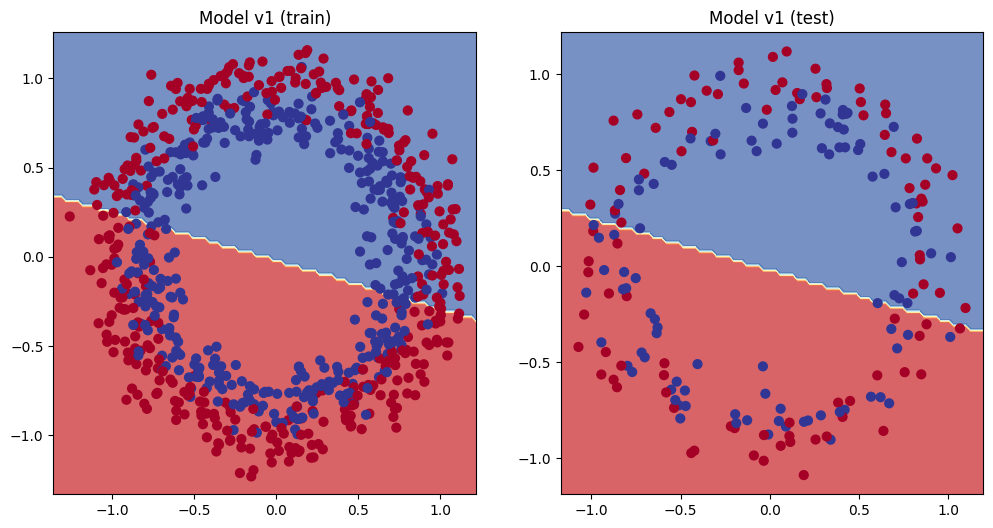

In [22]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Model v1 (train)")
plot_decision_boundary(model_v1,X_train,y_train)
plt.subplot(1,2,2)
plt.title("Model v1 (test)")
plot_decision_boundary(model_v1,X_test,y_test)

Still no good!

Let's check if this model will at least work for linear data

In [45]:
x_regression_data = torch.arange(0,1,.01).unsqueeze(dim=1)
y_regression_data = .3 + .7*x_regression_data
split = train_test_split(x_regression_data,y_regression_data)
x_train_reg, x_test_reg, y_train_reg, y_test_reg = split

In [46]:
split[0].shape

torch.Size([75, 1])

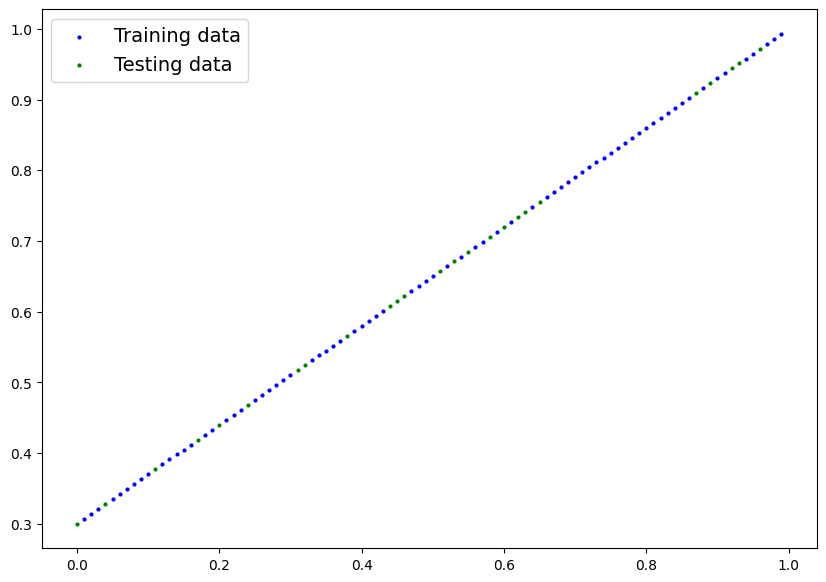

In [29]:
plot_predictions(train_data=x_train_reg,train_labels=y_train_reg,test_data=x_test_reg,test_labels=y_test_reg)

In [34]:
print(device)

cuda


In [52]:
model_2 = nn.Sequential(nn.Linear(1,10),nn.Linear(10,10), nn.Linear(10,1)).to(device)
loss_function = nn.L1Loss()
optimizer = SGD(model_2.parameters(), lr=0.01)
x_train_reg = x_train_reg.to(device)
x_test_reg = x_test_reg.to(device)
y_train_reg = y_train_reg.to(device)
y_test_reg = y_test_reg.to(device)

In [53]:
torch.manual_seed(42)
epochs = 1000
model_2.train()
for epoch in range(epochs):
    #make predictions
    pred = model_2(x_train_reg)
    #round the predictions to get the labels
    #calculate the loss
    loss = loss_function(pred,y_train_reg)
    #zero the gradients
    optimizer.zero_grad()
    #backpropagate
    loss.backward()
    #update the parameters
    optimizer.step()
    #test the model
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(x_test_reg).squeeze()
        test_loss = loss_function(test_pred,y_test_reg)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Training Loss: {loss} | Test Loss: {test_loss}")

Epoch 0 Training Loss: 0.7966864109039307 | Test Loss: 0.7642546892166138
Epoch 100 Training Loss: 0.030086318030953407 | Test Loss: 0.19674701988697052
Epoch 200 Training Loss: 0.026805652305483818 | Test Loss: 0.19584932923316956
Epoch 300 Training Loss: 0.022655917331576347 | Test Loss: 0.1951933354139328
Epoch 400 Training Loss: 0.022671492770314217 | Test Loss: 0.1950875222682953
Epoch 500 Training Loss: 0.022416403517127037 | Test Loss: 0.19515298306941986
Epoch 600 Training Loss: 0.021194521337747574 | Test Loss: 0.1954125463962555
Epoch 700 Training Loss: 0.020318692550063133 | Test Loss: 0.19529224932193756
Epoch 800 Training Loss: 0.02014964073896408 | Test Loss: 0.19551078975200653
Epoch 900 Training Loss: 0.019871192052960396 | Test Loss: 0.19552680850028992


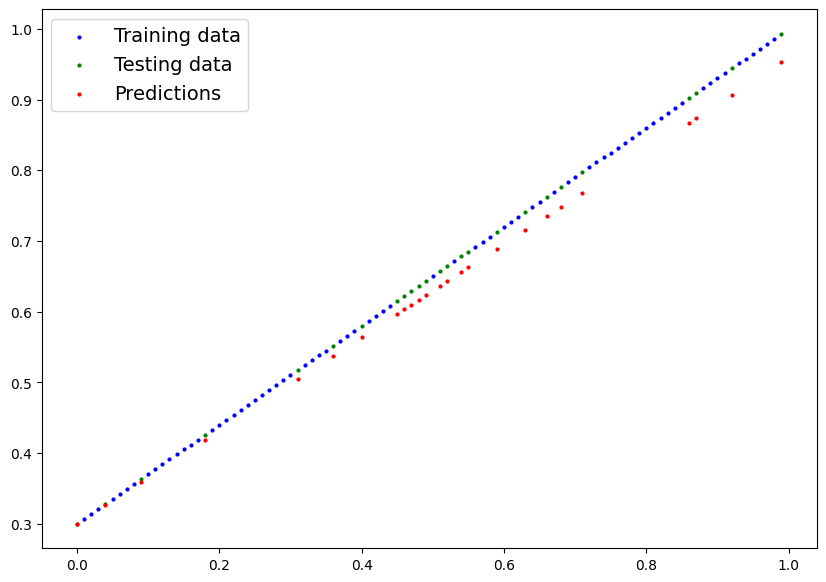

In [58]:
model_2.eval()
with torch.inference_mode():
    y_preds = model_2(x_test_reg)
plot_predictions(train_data=x_train_reg.cpu(),train_labels=y_train_reg.cpu(),test_data=x_test_reg.cpu(),test_labels=y_test_reg.cpu(),predictions=y_preds.cpu())

So the model is good for something... as long as it's linear. 

But how can we build a model to predict non-linear data?

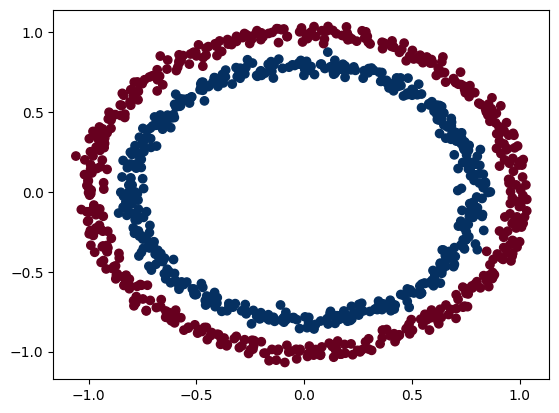

In [59]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [73]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = torch.from_numpy(x_train).float().to(device)
x_test = torch.from_numpy(x_test).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

In [80]:
class CircleModel_V2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(2, 10)
        self.layer_2 = nn.Linear(10, 10)
        self.layer_3 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModel_V2().to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = SGD(model_3.parameters(), lr=0.1)

In [81]:
torch.manual_seed(42)
epochs = 1000
model_3.train()
for epoch in range(epochs):
    #make predictions and extract labels (forward pass)
    pred = model_3(x_train).squeeze()
    labels = torch.round(torch.sigmoid(pred))
    #calculate the loss and accuracy
    loss = loss_function(pred, y_train)
    train_accuracy = accuracy_fn(labels, y_train)
    #zero the gradients
    optimizer.zero_grad()
    #backpropagate
    loss.backward()
    #update the parameters
    optimizer.step()
    #test the model
    model_3.eval()
    with torch.inference_mode():
        test_pred = model_3(x_test).squeeze()
        test_labels = torch.round(torch.sigmoid(test_pred))
        test_loss = loss_function(test_pred, y_test)
        test_accuracy = accuracy_fn(test_labels, y_test)
        if epoch % 100 == 0:
            print(f"Epoch {epoch} Training Loss: {loss} Training Accuracy: {train_accuracy} Test Loss: {test_loss} Test Accuracy: {test_accuracy}")

Epoch 0 Training Loss: 0.6929463148117065 Training Accuracy: 50.0 Test Loss: 0.6931881308555603 Test Accuracy: 50.0
Epoch 100 Training Loss: 0.691152811050415 Training Accuracy: 52.875 Test Loss: 0.6910240054130554 Test Accuracy: 52.499996185302734
Epoch 200 Training Loss: 0.6897744536399841 Training Accuracy: 53.375 Test Loss: 0.6893960237503052 Test Accuracy: 55.0
Epoch 300 Training Loss: 0.6879494190216064 Training Accuracy: 52.999996185302734 Test Loss: 0.687231719493866 Test Accuracy: 56.0
Epoch 400 Training Loss: 0.6851678490638733 Training Accuracy: 52.749996185302734 Test Loss: 0.6841148138046265 Test Accuracy: 56.5
Epoch 500 Training Loss: 0.6810224652290344 Training Accuracy: 52.749996185302734 Test Loss: 0.6794120073318481 Test Accuracy: 56.5
Epoch 600 Training Loss: 0.675148606300354 Training Accuracy: 54.5 Test Loss: 0.6728507876396179 Test Accuracy: 56.0
Epoch 700 Training Loss: 0.6665886044502258 Training Accuracy: 58.375 Test Loss: 0.6632164716720581 Test Accuracy: 58.9